In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_estate = pd.read_csv('Ames Real Estate Data.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/308385667.py:2: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate = pd.read_csv('Ames Real Estate Data.csv', index_col=0)
/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/308385667.py:3: DtypeWarning: Columns (35,39,80,86) have mixed types. Specify dtype option on import or set low_memory=False.
  real_coords = pd.read_csv("real_estate_with_coordinates.csv")


In [3]:
print(housing.shape)
print(real_estate.shape)
print(real_coords.shape)

(2580, 81)
(22213, 90)
(22213, 92)


In [4]:
# housing[housing.duplicated('PID', keep=False) == True]
# Only one row is duplicated in housing df
# Once dropped there are no duplicate PID values
housing = housing.drop_duplicates()
real_coords = real_coords.drop_duplicates()

In [21]:
real_coords[real_coords.duplicated('GeoRefNo', keep=False) == True]#['GeoRefNo'].value_counts()

In [ ]:
# First instance of duplicated GeoRefNo is 43/44
row_index1 = 43
row_index2 = 44

# Comparison of two rows
differing_columns = real_coords.columns[real_coords.iloc[row_index1] != real_coords.iloc[row_index2]]

real_coords[differing_columns].iloc[[43,44]]

real_coords[["GeoRefNo","YrSold_YYYY","MoSold_MM","SalePrice"]].iloc[[43,44]]


# NaN DOES NOT equal Nan.
# Repeated values seem to indicate repeat sales of the same home

real_estate_columns_to_keep = ['GeoRefNo','YrSold_YYYY','MoSold_MM',
                               'Prop_Addr', 'MA_Zip1','latitude', 'longitude']

housing_coords = pd.merge(housing, real_estate_with_coordinates[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# housing_coords = housing_coords.drop_duplicates()
housing_coords.shape

In [ ]:
# This indicates the info should be taken from housing df as it is much more consistent:
# But also that the data must be included because it's different sales of the same homes
housing_coords[['MoSold', 'YrSold',"MoSold_MM", "YrSold_YYYY"]].isna().sum()

In [ ]:
housing_coords.YrSold_YYYY = housing_coords.YrSold_YYYY.fillna(0).astype('int')
housing_coords.MoSold_MM = housing_coords.MoSold_MM.fillna(0).astype('int')

In [ ]:
housing_coords.loc[housing_coords.YrSold_YYYY!=0][['YrSold','YrSold_YYYY']]
#Doesn't match at all! none of the real estate data sales matter so we will only use left df for year/month

In [ ]:
housing_coords.loc[housing_coords.YrSold==housing_coords.YrSold_YYYY]

In [ ]:
# This shows there are 43 duplicated homes (sold more than once):
# housing_coords[housing_coords.duplicated(['PID'], keep=False) == True]#['PID','YrSold_YYYY','MoSold_MM']

In [448]:
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']

housing_coords = pd.merge(housing, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

housing_coords = housing_coords.drop_duplicates()
housing_coords.reset_index()
housing_coords.shape

(2579, 86)

In [279]:
# Remove missing gps data rows:
housing_coords = housing_coords.dropna(subset=['latitude'])

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']

# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014

In [18]:
housing_coords[['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']].isna().sum().sort_values()

GeoRefNo     0
Prop_Addr    0
MA_Zip1      0
latitude     0
longitude    0
dtype: int64

In [ ]:
housing_coords.isna().sum()#.sort_values()

In [ ]:
housing_coords.isna().sum(axis=1).sort_values()

In [ ]:
pd.set_option('display.max_columns', 20)
housing_coords.iloc[[683]]#.isna().sum(axis=1)

In [ ]:
## housing_coords.iloc[[690]].

In [ ]:
# THESE SHOULD BE DROPPED: No address or zip code or gps
housing_coords = housing_coords.dropna(subset=['Prop_Addr'])

housing_coords.loc[housing_coords.latitude.isna()]


# To Find
- What are the columns with the most NA values?
- when rows have many NAs, what are the most common NAs?
  - does this match the general?

In [111]:
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Calculate the distance
    distance = radius * c
    return distance

# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# Now, 'DistanceToISU' column contains the distance of each property to Iowa State University
housing_coords

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude,PricePerSF,DistanceToISU
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,2010,WD,Normal,909176150.0,436 HAYWARD AVE,50010.0,42.018564,-93.651619,147.196262,0.422452
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,2009,WD,Normal,905476230.0,3416 WEST ST,50014.0,42.024855,-93.663671,132.983794,0.827516
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,2007,WD,Normal,911128020.0,320 S 2ND ST,50010.0,42.021548,-93.614068,124.775225,1.728802
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,2009,WD,Normal,535377150.0,1524 DOUGLAS AVE,50010.0,42.037391,-93.612207,109.720885,2.041677
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,2009,WD,Normal,534177230.0,2304 FILLMORE AVE,50010.0,42.044554,-93.631818,136.336336,1.640861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,...,2009,WD,Normal,903205040.0,1021 RIDGEWOOD AVE,50010.0,42.032102,-93.626373,127.100840,1.228042
2619,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,...,2009,WD,Normal,905402060.0,3619 MARY CIR,50014.0,42.027669,-93.666138,80.553953,0.986488
2620,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,...,2007,WD,Normal,909275030.0,2140 SUNSET DR 2142,16801.0,42.020129,-93.643832,72.427572,0.324492
2621,907192040,1842,217500,60,RL,NaN,8826,Pave,NaN,Reg,...,2007,WD,Normal,907192040.0,5319 CLEMENS BLVD,50014.0,42.016802,-93.689748,118.078176,2.218386


In [22]:
housing_coords

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,0,3,2010,WD,Normal,909176150.0,436 HAYWARD AVE,50010.0,42.018564,-93.651619
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,2,2009,WD,Normal,905476230.0,3416 WEST ST,50014.0,42.024855,-93.663671
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,11,2007,WD,Normal,911128020.0,320 S 2ND ST,50010.0,42.021548,-93.614068
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,0,5,2009,WD,Normal,535377150.0,1524 DOUGLAS AVE,50010.0,42.037391,-93.612207
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,0,11,2009,WD,Normal,534177230.0,2304 FILLMORE AVE,50010.0,42.044554,-93.631818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,...,0,5,2009,WD,Normal,903205040.0,1021 RIDGEWOOD AVE,50010.0,42.032102,-93.626373
2619,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,...,0,6,2009,WD,Normal,905402060.0,3619 MARY CIR,50014.0,42.027669,-93.666138
2620,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,...,0,8,2007,WD,Normal,909275030.0,2140 SUNSET DR 2142,16801.0,42.020129,-93.643832
2621,907192040,1842,217500,60,RL,NaN,8826,Pave,NaN,Reg,...,0,7,2007,WD,Normal,907192040.0,5319 CLEMENS BLVD,50014.0,42.016802,-93.689748


This is above grade ppsf.  could add basement sqft for properties that have finished basements?

In [24]:
housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

In [27]:
housing_coords.Fireplaces.value_counts()

0    1201
1    1093
2     191
3      11
4       1
Name: Fireplaces, dtype: int64

In [32]:
housing_coords.loc[housing_coords.Fireplaces==3]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MoSold,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude,PricePerSF
294,535325460,2039,167000,30,RL,118.0,21299,Pave,NaN,Reg,...,12,2006,COD,Abnorml,535325460.0,1704 BURNETT AVE,50010.0,42.039331,-93.615437,81.902894
717,533253030,1235,214000,120,RL,NaN,3760,Pave,NaN,IR1,...,5,2006,WD,Normal,533253030.0,2008 PINEHURST DR,50010.0,42.042733,-93.649317,173.279352
792,533125120,2826,334000,60,RL,105.0,11025,Pave,NaN,Reg,...,10,2006,WD,Normal,533125120.0,3130 GREENWOOD RD,50010.0,42.048600,-93.653678,118.188252
1164,528102140,2772,462000,60,RL,110.0,14257,Pave,NaN,Reg,...,6,2009,WD,Normal,528102140.0,3209 SEDWICK ST,50010.0,42.063049,-93.655918,166.666667
1335,528142110,1944,360000,20,RL,90.0,12378,Pave,NaN,IR1,...,11,2006,WD,Normal,528142110.0,3049 HARRISON RD,50010.0,42.059192,-93.650488,185.185185
1640,909426060,2315,257000,60,RL,78.0,15600,Pave,NaN,Reg,...,7,2006,WD,Normal,909426060.0,2019 FRILEY RD,50014.0,42.014945,-93.639841,111.015119
2034,535177110,1721,174850,20,RL,80.0,9736,Pave,NaN,Reg,...,4,2007,WD,Normal,535177110.0,2130 DUFF AVE,50010.0,42.044011,-93.612477,101.597908
2143,909428180,1560,201000,20,RL,NaN,25485,Pave,NaN,IR1,...,5,2007,WD,Normal,909428180.0,2118 GREENBRIAR CIR,50014.0,42.012482,-93.640581,128.846154
2253,526355080,2704,345000,80,RL,75.0,13860,Pave,NaN,Reg,...,7,2009,WD,Normal,526355080.0,2802 THOMPSON DR,50010.0,42.049294,-93.615484,127.588757
2275,905401100,1867,190000,20,RL,NaN,10708,Pave,NaN,IR1,...,11,2009,COD,Normal,905401100.0,3611 OAKLAND ST,50014.0,42.028483,-93.666413,101.767542


In [31]:
housing_coords.describe()

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GeoRefNo,MA_Zip1,latitude,longitude,PricePerSF
count,2.497000e+03,2497.000000,2497.000000,2497.000000,2046.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,...,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2.497000e+03,2497.000000,2497.000000,2497.000000,2497.000000
mean,7.126251e+08,1481.377653,178351.138166,56.507809,68.723851,10100.215459,6.053264,5.624750,1970.488987,1983.909091,...,16.549459,1.625951,46.826992,6.146976,2007.835002,7.126251e+08,50146.209451,42.034420,-93.642650,121.329330
std,1.885870e+08,482.951419,75090.098440,41.790592,22.726598,8123.376206,1.353106,1.121146,29.588537,20.441995,...,57.467647,30.503629,479.122474,2.658521,1.311931,1.885870e+08,4025.030829,0.018101,0.025979,30.133090
min,5.263011e+08,334.000000,12789.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,1.000000,2006.000000,5.263011e+08,783.000000,41.986495,-93.692701,15.371394
25%,5.284900e+08,1110.000000,130000.000000,20.000000,58.000000,7438.000000,5.000000,5.000000,1954.000000,1966.000000,...,0.000000,0.000000,0.000000,4.000000,2007.000000,5.284900e+08,50010.000000,42.022174,-93.661020,101.190476
50%,5.354521e+08,1433.000000,160000.000000,50.000000,68.000000,9416.000000,6.000000,5.000000,1972.000000,1992.000000,...,0.000000,0.000000,0.000000,6.000000,2008.000000,5.354521e+08,50010.000000,42.034765,-93.640459,120.101138
75%,9.071352e+08,1732.000000,210000.000000,70.000000,80.000000,11475.000000,7.000000,6.000000,1999.000000,2003.000000,...,0.000000,0.000000,0.000000,8.000000,2009.000000,9.071352e+08,50014.000000,42.048992,-93.621715,139.088729
max,1.007100e+09,4316.000000,755000.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,...,576.000000,800.000000,15500.000000,12.000000,2010.000000,1.007100e+09,99516.000000,42.063342,-93.578327,276.250881


In [33]:
housing_coords.Neighborhood.value_counts()

NAmes      402
CollgCr    236
OldTown    201
Edwards    159
Gilbert    142
Somerst    139
Sawyer     136
NWAmes     123
SawyerW    111
NridgHt    110
BrkSide    102
Mitchel     99
Crawfor     88
IDOTRR      73
NoRidge     67
Timber      52
StoneBr     43
SWISU       40
MeadowV     34
ClearCr     34
BrDale      29
Blmngtn     23
Veenker     23
NPkVill     22
Greens       8
Landmrk      1
Name: Neighborhood, dtype: int64

In [106]:
housing_coords.corr()
# only 43 columns numerical

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/88149535.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_coords.corr()


,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GeoRefNo,MA_Zip1,latitude,longitude,PricePerSF
PID,1.000000,-0.117554,-0.228917,-0.012342,-0.099348,0.039542,-0.250360,0.116984,-0.337043,-0.126682,...,-0.032325,-0.009177,-0.016844,-0.065565,-0.001673,1.000000,0.019768,-0.805275,-0.208980,-0.191055
GrLivArea,-0.117554,1.000000,0.735870,0.075574,0.343228,0.248088,0.577967,-0.115516,0.238882,0.311495,...,0.101863,0.053068,-0.020647,0.039799,-0.007426,-0.117554,-0.009025,0.196566,-0.138745,-0.095100
SalePrice,-0.228917,0.735870,1.000000,-0.074732,0.368226,0.275300,0.794030,-0.109348,0.545151,0.509824,...,0.122067,0.026005,-0.021669,0.016086,0.005458,-0.228917,-0.011569,0.276901,-0.251803,0.572530
MSSubClass,-0.012342,0.075574,-0.074732,1.000000,-0.436390,-0.193262,0.065427,-0.080996,0.065167,0.064418,...,-0.048367,-0.009926,-0.032909,0.006659,-0.035798,-0.012342,-0.030726,0.012896,0.081998,-0.187304
LotFrontage,-0.099348,0.343228,0.368226,-0.436390,1.000000,0.448272,0.197626,-0.050540,0.111580,0.073375,...,0.080918,0.088176,0.017538,0.011211,0.005319,-0.099348,-0.001497,0.099211,-0.117253,0.161782
LotArea,0.039542,0.248088,0.275300,-0.193262,0.448272,1.000000,0.087418,-0.031882,0.015735,0.013189,...,0.055375,0.051327,0.036174,0.014452,-0.010005,0.039542,0.004899,-0.037945,-0.099742,0.107390
OverallQual,-0.250360,0.577967,0.794030,0.065427,0.197626,0.087418,1.000000,-0.111473,0.572345,0.538256,...,0.050059,-0.007185,-0.022590,0.015865,0.006307,-0.250360,-0.015533,0.307458,-0.257820,0.494892
OverallCond,0.116984,-0.115516,-0.109348,-0.080996,-0.050540,-0.031882,-0.111473,1.000000,-0.401749,0.057527,...,0.051088,-0.020437,0.052680,0.009371,0.013455,0.116984,0.015551,-0.099946,0.189311,0.023276
YearBuilt,-0.337043,0.238882,0.545151,0.065167,0.111580,0.015735,0.572345,-0.401749,1.000000,0.570388,...,-0.046012,0.003181,-0.031650,-0.012414,0.019388,-0.337043,-0.022937,0.238308,-0.423452,0.546037
YearRemodAdd,-0.126682,0.311495,0.509824,0.064418,0.073375,0.013189,0.538256,0.057527,0.570388,1.000000,...,-0.045441,-0.019995,-0.016087,-0.005386,0.065023,-0.126682,-0.018879,0.153075,-0.315801,0.421197


/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/2901858937.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_coords.corr()


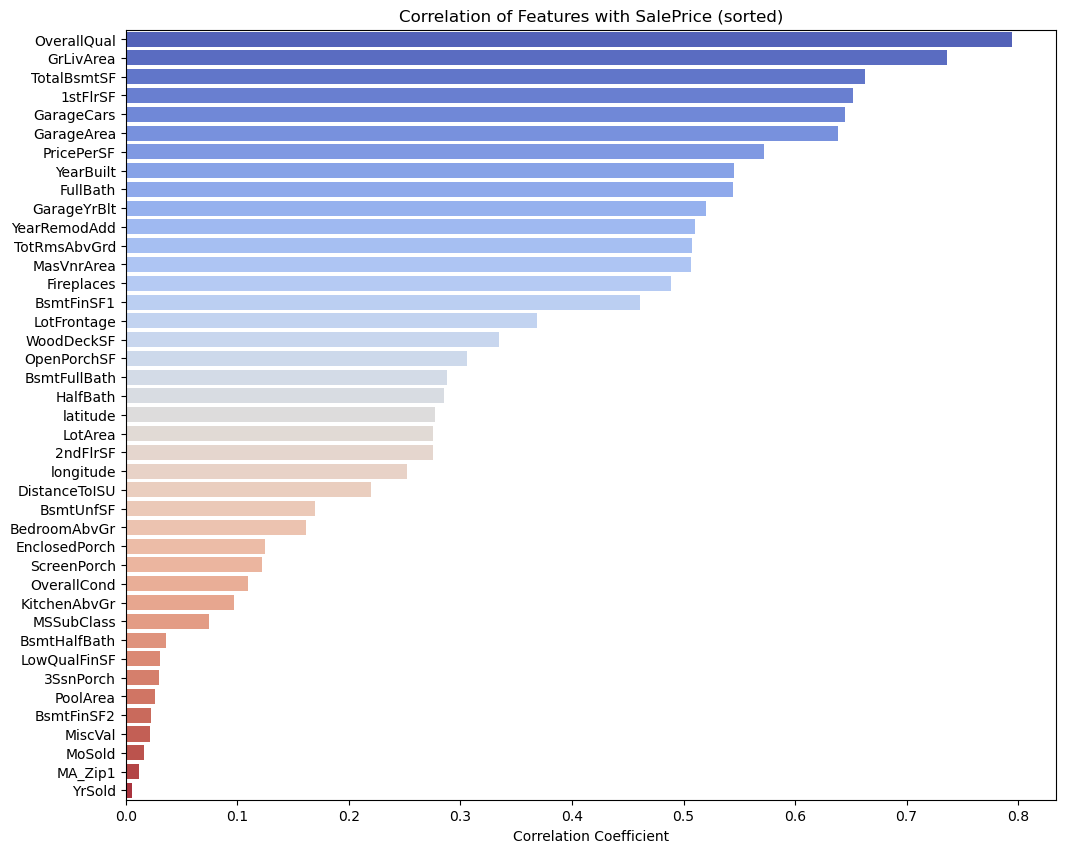

In [112]:
# Calculate the correlation matrix
corr_matrix = housing_coords.corr()

# Get the correlation of all features with 'SalePrice', sort them, and drop 'SalePrice'
sorted_corrs = abs(corr_matrix['SalePrice']).sort_values(ascending=False).drop(['SalePrice','PID','GeoRefNo'])

# Plot the sorted correlations
plt.figure(figsize=(12, 10))
sns.barplot(y=sorted_corrs.index, x=abs(sorted_corrs.values), palette='coolwarm')

plt.title('Correlation of Features with SalePrice (sorted)')
plt.xlabel('Correlation Coefficient')
plt.show()

Ames was incorporated territory in 1864.  No houses from before 1950?  
Seems like everything pre-1950 was placed into 1950.  Makes for inaccurate levels of importance

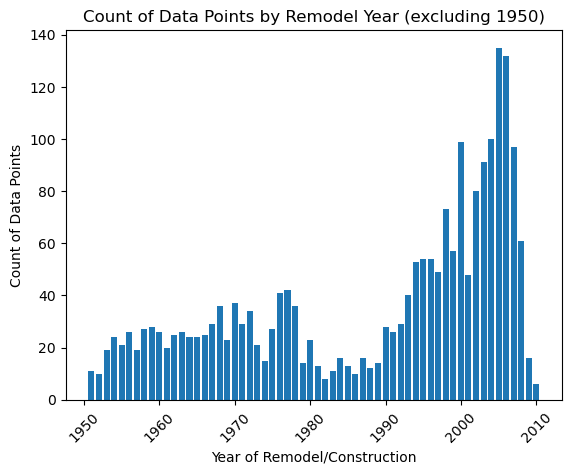

In [93]:
remodel_count = housing_coords.groupby('YearRemodAdd').count()[['PID']].reset_index().iloc[1:]

plt.bar(remodel_count.YearRemodAdd,remodel_count.PID)
plt.xticks(rotation=45)
plt.xlabel('Year of Remodel/Construction')
plt.ylabel('Count of Data Points')
plt.title('Count of Data Points by Remodel Year (excluding 1950)')
plt.show()

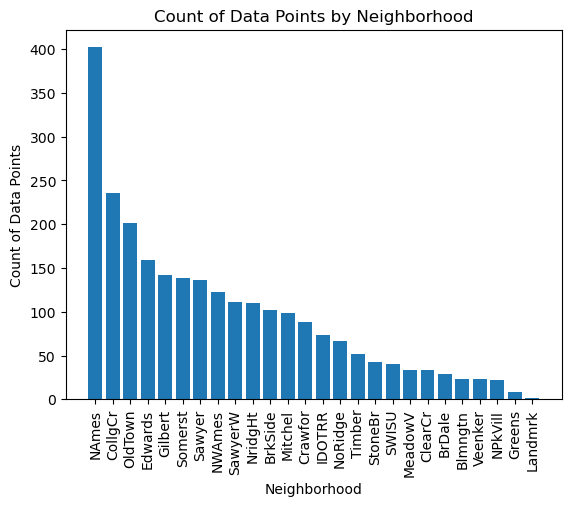

In [103]:
neighborhood_count = housing_coords.groupby('Neighborhood').count()[[
    'PID']].reset_index().sort_values(by='PID', ascending=False)
plt.bar(neighborhood_count.Neighborhood,remodel_count.PID)
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Count of Data Points')
plt.title('Count of Data Points by Neighborhood')
plt.show()

Average distance of each neighborhood to ISU

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/1019412584.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  neighborhood_distance = housing_coords.groupby('Neighborhood').mean()[['DistanceToISU']].reset_index()


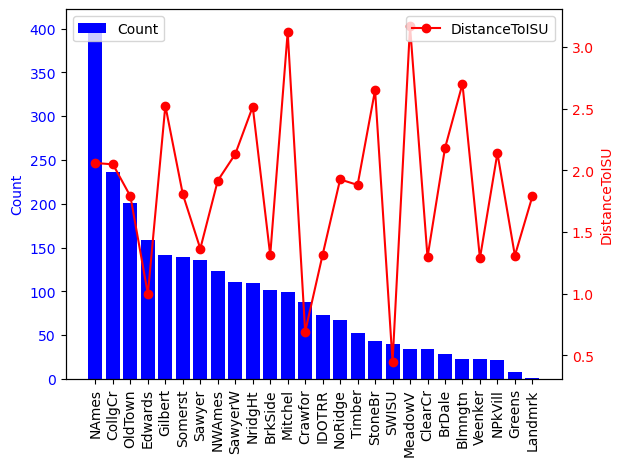

In [133]:
# neighborhood_distance = housing_coords.groupby('Neighborhood').mean()[['DistanceToISU']].reset_index()
# neighborhood_df = neighborhood_distance.merge(neighborhood_count).rename({'PID':'Count'},axis=1)


neighborhood_df = housing_coords.groupby('Neighborhood').agg(
    {'DistanceToISU': 'mean', 'PID': 'count'}).reset_index().rename({'PID':'Count'},axis=1)

neighborhood_df = neighborhood_df.sort_values(by='Count', ascending=False)

# Set up the figure and axes
fig, ax1 = plt.subplots()

# Plot Count on the left y-axis
ax1.bar(neighborhood_df['Neighborhood'], neighborhood_df['Count'], color='blue', label='Count')
ax1.set_ylabel('Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for DistanceToISU
ax2 = ax1.twinx()
ax2.plot(neighborhood_df['Neighborhood'], neighborhood_df['DistanceToISU'], color='red', 
         marker='o', label='DistanceToISU')
ax2.set_ylabel('DistanceToISU', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis label
plt.xlabel('Neighborhood')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels by 90 degrees
ax1.tick_params(axis='x', rotation=90)

# Show the plot
plt.show()





In [149]:
housing_coords.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

In [168]:
def Compare_Cols(col1, col2, col1_func='mean', col2_func='mean'):
    neighborhood_df = housing_coords.groupby('Neighborhood').agg(
        {col1: col1_func, col2: col2_func}).reset_index()#.rename({'PID':'Count'},axis=1)

    neighborhood_df = neighborhood_df.sort_values(by=col2, ascending=False)

    # Set up the figure and axes
    fig, ax1 = plt.subplots()

    # Plot Count on the left y-axis
    ax1.bar(neighborhood_df['Neighborhood'], neighborhood_df[col2], color='blue', label=col2)
    ax1.set_ylabel(col2, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for DistanceToISU
    ax2 = ax1.twinx()
    ax2.plot(neighborhood_df['Neighborhood'], neighborhood_df[col1], color='red', 
             marker='o', label=col1)
    ax2.set_ylabel(col1, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Set x-axis label
    ax1.set_xlabel('Neighborhood')

    # Add legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Rotate x-axis labels by 90 degrees
    ax1.tick_params(axis='x', rotation=90)

    # Show the plot
    plt.show()
    

In [169]:
def Compare_Cols2(col1, col2, col1_func='mean', col2_func='mean'):
    neighborhood_df = housing_coords.groupby('Neighborhood').agg(
        {col1: col1_func, col2: col2_func}).reset_index()

    neighborhood_df = neighborhood_df.sort_values(by=col2, ascending=False)

    # Set up the figure and axes
    fig, ax = plt.subplots()

    # Scatter plot
    ax.scatter(neighborhood_df[col2], neighborhood_df[col1], color='blue', label=col1)

    # Add labels to each point
#     for i, txt in enumerate(neighborhood_df['Neighborhood']):
#         ax.annotate(txt, (neighborhood_df[col2].iloc[i], neighborhood_df[col1].iloc[i]))

    # Set axis labels
    ax.set_xlabel(col2)
    ax.set_ylabel(col1)

    # Show the plot
    plt.show()

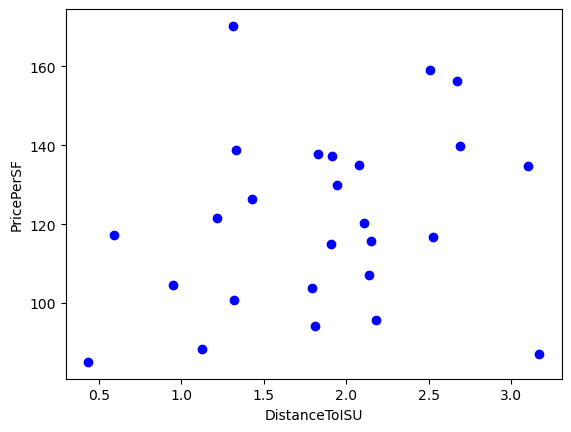

In [171]:
Compare_Cols2('PricePerSF','DistanceToISU','median','median')

In [173]:
housing_coords.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

# This row of data needs to be corrected:

In [181]:
housing_coords[['YearRemodAdd','YearBuilt']]
housing_coords.loc[housing_coords['YearRemodAdd']-housing_coords['YearBuilt']<0][['YearRemodAdd','YearBuilt']]

,YearRemodAdd,YearBuilt
2067,2001,2002


In [382]:
housing_coords.loc[housing_coords['YearRemodAdd']-housing_coords['YearBuilt']<0][['PID','YearRemodAdd','YearBuilt']]

,PID,YearRemodAdd,YearBuilt


In [381]:
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

In [383]:
housing_coords.loc[housing_coords.PID==907194160][['PID','YearRemodAdd','YearBuilt']]

,PID,YearRemodAdd,YearBuilt
2067,907194160,2002,2002


In [197]:
housing_coords.loc[housing_coords.GarageArea==0]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude,PricePerSF,DistanceToISU
18,909101060,864,67000,30,RL,45.0,8248,Pave,Grvl,Reg,...,2008,WD,Normal,909101060.0,2910 WOOD ST,50014.0,42.022082,-93.656927,77.546296,0.494928
23,923228080,1092,98000,160,RM,21.0,1477,Pave,NaN,Reg,...,2008,WD,Normal,923228080.0,626 MEADOW PL,50021.0,41.992156,-93.603086,89.743590,3.167591
49,535379110,1534,148000,70,RL,60.0,10800,Pave,Grvl,Reg,...,2007,WD,Normal,535379110.0,1412 KELLOGG AVE,50010.0,42.035947,-93.613865,96.479791,1.921067
53,902106130,936,109500,30,RM,56.0,4485,Pave,Grvl,Reg,...,2010,WD,Normal,902106130.0,1010 GRAND AVE,50010.0,42.031462,-93.620208,116.987179,1.499834
55,909176170,2592,150000,90,RL,60.0,10890,Pave,NaN,Reg,...,2007,WD,AdjLand,909176170.0,426 HAYWARD AVE 428,50014.0,42.018691,-93.651622,57.870370,0.414907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,923226250,1092,76000,160,RM,21.0,1476,Pave,NaN,Reg,...,2010,WD,Normal,923226250.0,619 MEADOW PL,50327.0,41.992380,-93.603012,69.597070,3.159632
2523,534450110,666,64500,20,RL,50.0,5000,Pave,NaN,Reg,...,2007,WD,Normal,534450110.0,1441 SUMMIT AVE,50236.0,42.035661,-93.629583,96.846847,1.231004
2556,904101070,3086,200500,50,RL,138.0,18030,Pave,NaN,IR1,...,2007,WD,Normal,904101070.0,2824 ROSS RD,50014.0,42.033285,-93.656243,64.970836,0.785685
2583,905101310,1768,136500,90,RL,72.0,10778,Pave,NaN,Reg,...,2010,WD,Normal,905101310.0,3905 QUEBEC ST,50014.0,42.033393,-93.671295,77.205882,1.381743


In [184]:
housing_coords.GarageType.value_counts()

Attchd     1490
Detchd      690
BuiltIn     146
Basment      26
2Types       18
CarPort       8
Name: GarageType, dtype: int64

In [185]:
housing_coords.shape

(2497, 88)

In [341]:
print(housing['GarageCars'].value_counts())
print('\n')
print(housing['GarageCars'].isna().value_counts())

2.0    1439
1.0     712
3.0     285
0.0     127
4.0      14
5.0       1
Name: GarageCars, dtype: int64


False    2578
True        1
Name: GarageCars, dtype: int64


In [ ]:
# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)
mode_GarageCars = housing_coords['GarageCars'].mode()[0] # 1 N/A
housing_coords['GarageCars'].fillna(mode_GarageCars, inplace=True)
mode_BsmtHalfBath = housing_coords['BsmtHalfBath'].mode()[0] # 2 N/A
housing_coords['BsmtHalfBath'].fillna(mode_BsmtHalfBath, inplace=True)

# Unnecessary since fixed with the other basement/garage variables in specified row
    # # Fill with Average (Numerical) Value:
    # mean_GarageArea = housing_coords['GarageArea'].mean() # 1 N/A
    # housing_coords['GarageArea'].fillna(mean_GarageArea, inplace=True)
    # mean_BsmtUnfSF = housing_coords['BsmtUnfSF'].mean() # 1 N/A
    # housing_coords['BsmtUnfSF'].fillna(mean_BsmtUnfSF, inplace=True)
    # mean_TotalBsmtSF = housing_coords['TotalBsmtSF'].mean() # 1 N/A
    # housing_coords['TotalBsmtSF'].fillna(mean_TotalBsmtSF, inplace=True)
    
    
# Fill with Middle (Numerical) Value:
median_LotFrontage = housing_coords['LotFrontage'].median() # 462 N/A
housing_coords['LotFrontage'].fillna(median_LotFrontage, inplace=True)

# Fill to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

In [204]:
# DELETE UTILITIES COLUMN, it is 2577/2579 with same value
housing.Utilities.value_counts() # 0 N/A

housing_coords.drop('Utilities',axis=1,inplace=True)


AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64

In [313]:
# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

In [362]:
# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea

idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars


In [301]:
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
mode_MasVnrType

'BrkFace'

MasVnrType & MasVnrArea (Masonry veneer type and area): For cases where both are NA, impute with None and 0. For one entry with area, impute type as “BrkFace” since it’s the most common.

In [280]:
# idx = np.where((housing_coords['MasVnrArea']!=0)&(housing_coords['MasVnrType']=='None'))
# idx = np.where((housing_coords['MasVnrArea'].isna())&(housing_coords['MasVnrType'].isna()))

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())

housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')

mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]

idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

,MasVnrArea,MasVnrType
180,0.0,None
364,0.0,None
764,0.0,None
798,0.0,None
884,0.0,None
904,0.0,None
1055,0.0,None
1181,0.0,None
1379,0.0,None
1579,0.0,None


In [296]:
housing_coords.MasVnrType.value_counts()

None       1520
BrkFace     786
Stone       171
BrkCmn       20
Name: MasVnrType, dtype: int64

In [340]:
varitest = 'GarageArea'
print(housing_coords[varitest].value_counts())
print('\n')
print(housing_coords[varitest].isna().value_counts())
print('\n')
print(housing_coords[varitest].mean())
print('\n')

idx3 = (housing_coords[varitest]!=0) & (housing_coords['GarageType']=='Detchd')
housing_coords.loc[idx3, 'GarageArea'].mean()
910201180

0.0       119
576.0      90
440.0      85
484.0      68
240.0      62
         ... 
862.0       1
1085.0      1
307.0       1
815.0       1
192.0       1
Name: GarageArea, Length: 570, dtype: int64


False    2496
True        1
Name: GarageArea, dtype: int64


466.6786858974359




413.80841799709725

In [323]:
housing_coords.loc[housing_coords.GarageCars.isna()][['GarageType','GarageArea','GarageCars']]

,GarageType,GarageArea,GarageCars
440,Detchd,NaN,NaN


# THIS MUST BE DONE REPEATEDLY FOR INDEXING IF DATA IS DROPPED\

housing_coords.reset_index(inplace=True)

In [373]:
housing_coords.drop('Utilities',axis=1,inplace=True)
housing_coords

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,0,3,2010,WD,Normal,909176150.0,436 HAYWARD AVE,50010.0,42.018564,-93.651619
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,2,2009,WD,Normal,905476230.0,3416 WEST ST,50014.0,42.024855,-93.663671
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,11,2007,WD,Normal,911128020.0,320 S 2ND ST,50010.0,42.021548,-93.614068
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,0,5,2009,WD,Normal,535377150.0,1524 DOUGLAS AVE,50010.0,42.037391,-93.612207
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,0,11,2009,WD,Normal,534177230.0,2304 FILLMORE AVE,50010.0,42.044554,-93.631818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,...,0,5,2009,WD,Normal,903205040.0,1021 RIDGEWOOD AVE,50010.0,42.032102,-93.626373
2619,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,...,0,6,2009,WD,Normal,905402060.0,3619 MARY CIR,50014.0,42.027669,-93.666138
2620,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,...,0,8,2007,WD,Normal,909275030.0,2140 SUNSET DR 2142,16801.0,42.020129,-93.643832
2621,907192040,1842,217500,60,RL,NaN,8826,Pave,NaN,Reg,...,0,7,2007,WD,Normal,907192040.0,5319 CLEMENS BLVD,50014.0,42.016802,-93.689748


In [368]:
housing_coords.Utilities.value_counts()

AllPub    2496
NoSewr       1
Name: Utilities, dtype: int64

In [385]:
housing_coords.Electrical.isna().value_counts()

False    2496
True        1
Name: Electrical, dtype: int64

In [389]:
housing_coords.loc[housing_coords.Electrical.isna()].isna().sum(axis=1)

2483    6
dtype: int64

# Lot Frontage Issue:

of the 4 lot categories Frontage is the only one that has na values but it is over 400

In [398]:
for varitest in ['LotFrontage','LotArea','LotConfig','LotShape']:
    print(varitest)
    print(housing_coords[varitest].value_counts())
    print('\n')
    print(housing_coords[varitest].isna().value_counts())
    print('\n')

LotFrontage
60.0     236
80.0     123
70.0     121
50.0     107
75.0      90
        ... 
313.0      1
195.0      1
111.0      1
137.0      1
138.0      1
Name: LotFrontage, Length: 125, dtype: int64


False    2046
True      451
Name: LotFrontage, dtype: int64


LotArea
9600     40
7200     37
6000     34
9000     24
10800    23
         ..
11613     1
8581      1
8139      1
14977     1
9554      1
Name: LotArea, Length: 1703, dtype: int64


False    2497
Name: LotArea, dtype: int64


LotConfig
Inside     1828
Corner      423
CulDSac     156
FR2          78
FR3          12
Name: LotConfig, dtype: int64


False    2497
Name: LotConfig, dtype: int64


LotShape
Reg    1582
IR1     833
IR2      69
IR3      13
Name: LotShape, dtype: int64


False    2497
Name: LotShape, dtype: int64




In [441]:
housing_coords.reset_index(inplace=True)

In [445]:
lot_na_df = housing_coords.loc[housing_coords['LotFrontage'].isna()][['LotFrontage','LotArea','LotConfig','LotShape']]

,LotFrontage,LotArea,LotConfig,LotShape
0,NaN,7890,Corner,Reg
13,NaN,9500,Inside,IR1
18,NaN,10603,Inside,IR1
27,NaN,2117,Inside,Reg
28,NaN,10382,Corner,IR1
...,...,...,...,...
2560,NaN,9125,Inside,IR1
2562,NaN,8917,Inside,IR1
2574,NaN,8854,Inside,Reg
2575,NaN,13680,CulDSac,IR1


I want the lot frontage to be calculated based on the percentage of lot area for that specific configuration. 

Shape shouldn't matter

In [450]:
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
lot_df2

LotFrontage       LotArea  PCT_Frontage
LotConfig LotShape                                         
Corner    IR1         92.637255  11561.519608      0.008013
          IR2         96.000000  10468.000000      0.009171
          IR3         88.000000   9078.000000      0.009694
          Reg         76.504202   9425.331933      0.008117
CulDSac   IR1         57.491803  13390.622951      0.004293
          IR2         48.941176  18021.294118      0.002716
          IR3        168.000000  23257.000000      0.007224
          Reg         33.000000   6105.000000      0.005405
FR2       IR1         71.083333  13637.250000      0.005212
          IR2         41.333333  12347.000000      0.003348
          Reg         58.625000   8351.025000      0.007020
FR3       IR1         87.500000   8918.750000      0.009811
          Reg         73.833333  10060.500000      0.007339
Inside    IR1         72.141711  10516.433155      0.006860
          IR2         87.684211  15783.210526      0.005556
          IR3         79.200000  58350.600000      0.001357
          Reg         64.565253   8671.861338      0.007445

In [419]:
lot_df3['PCT_Frontage'].to_dict()

{('Corner', 'IR1'): 0.8006385757824972,
 ('Corner', 'IR2'): 0.9170806266717616,
 ('Corner', 'IR3'): 0.9693765146508041,
 ('Corner', 'Reg'): 0.8145379415544872,
 ('CulDSac', 'IR1'): 0.4354045238222555,
 ('CulDSac', 'IR2'): 0.2742883565818696,
 ('CulDSac', 'IR3'): 0.7223631594788665,
 ('FR2', 'IR1'): 0.5212438969244777,
 ('FR2', 'IR2'): 0.33476418023271515,
 ('FR2', 'Reg'): 0.7020096335479776,
 ('FR3', 'IR1'): 0.9810791871058164,
 ('FR3', 'Reg'): 0.7361257548164478,
 ('Inside', 'IR1'): 0.6940382021375443,
 ('Inside', 'IR2'): 0.5453973004357084,
 ('Inside', 'IR3'): 0.1357312521208008,
 ('Inside', 'Reg'): 0.7482343194179432}

In [453]:
# Create a mapping dictionary for percentage factors
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)



In [454]:
housing_coords.iloc[list(lot_na_df.index)][['LotFrontage','LotArea','LotConfig','LotShape']]

,LotFrontage,LotArea,LotConfig,LotShape
0,64,7890,Corner,Reg
14,65,9500,Inside,IR1
19,73,10603,Inside,IR1
28,16,2117,Inside,Reg
29,83,10382,Corner,IR1
...,...,...,...,...
2604,63,9125,Inside,IR1
2606,61,8917,Inside,IR1
2618,66,8854,Inside,Reg
2619,59,13680,CulDSac,IR1


In [455]:
print(housing_coords['LotFrontage'].value_counts())
print('\n')
print(housing_coords['LotFrontage'].isna().value_counts())

60     69
71     66
63     65
80     58
73     55
       ..
156     1
173     1
136     1
250     1
180     1
Name: LotFrontage, Length: 186, dtype: int64


False    2579
Name: LotFrontage, dtype: int64


In [458]:
housing_coords.YrSold.isna().value_counts()

False    2579
Name: YrSold, dtype: int64

In [459]:
housing_coords.YrSold-housing_coords.YearBuilt

0        71
1        25
3        77
4       109
5         8
       ... 
2618     93
2619     54
2620     58
2621      7
2622     13
Length: 2579, dtype: int64

In [461]:
housing_coords[['YrSold', 'YearBuilt']]

,YrSold,YearBuilt
0,2010,1939
1,2009,1984
3,2007,1930
4,2009,1900
5,2009,2001
...,...,...
2618,2009,1916
2619,2009,1955
2620,2007,1949
2621,2007,2000


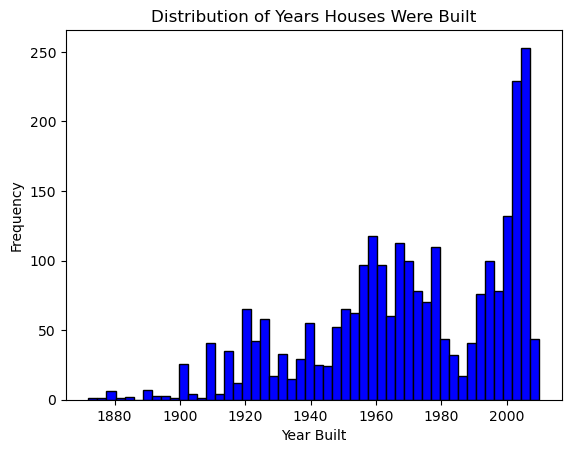

In [464]:
plt.hist(housing_coords['YearBuilt'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Years Houses Were Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()

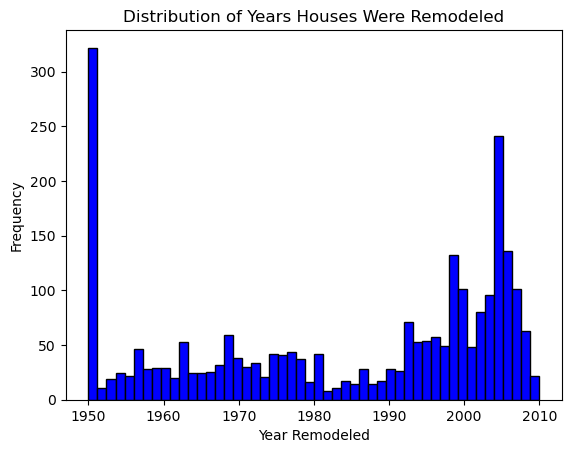

In [465]:
plt.hist(housing_coords['YearRemodAdd'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Years Houses Were Remodeled')
plt.xlabel('Year Remodeled')
plt.ylabel('Frequency')
plt.show()

In [471]:
housing_coords[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].describe()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
count,2577.000000,2577.000000,2579.000000,2579.000000
mean,0.435390,0.062088,1.550989,0.378054
std,0.518857,0.244557,0.545823,0.499184
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,2.000000,0.000000
75%,1.000000,0.000000,2.000000,1.000000
max,3.000000,2.000000,4.000000,2.000000


In [476]:
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']

housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']

housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)

In [477]:
housing_coords

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,GeoRefNo,Prop_Addr,MA_Zip1,latitude,longitude,BsmtBath,Bath
0,909176150,856,126000,30,RL,64,7890,Pave,NaN,Reg,...,2010,WD,Normal,909176150.0,436 HAYWARD AVE,50010.0,42.018564,-93.651619,1.0,1.0
1,905476230,1049,139500,120,RL,32,4235,Pave,NaN,Reg,...,2009,WD,Normal,905476230.0,3416 WEST ST,50014.0,42.024855,-93.663671,1.0,2.0
3,911128020,1001,124900,30,C (all),45,6060,Pave,NaN,Reg,...,2007,WD,Normal,911128020.0,320 S 2ND ST,50010.0,42.021548,-93.614068,0.0,1.0
4,535377150,1039,114000,70,RL,66,8146,Pave,NaN,Reg,...,2009,WD,Normal,535377150.0,1524 DOUGLAS AVE,50010.0,42.037391,-93.612207,0.0,1.0
5,534177230,1665,227000,60,RL,63,8400,Pave,NaN,Reg,...,2009,WD,Normal,534177230.0,2304 FILLMORE AVE,50010.0,42.044554,-93.631818,1.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,903205040,952,121000,30,RL,66,8854,Pave,NaN,Reg,...,2009,WD,Normal,903205040.0,1021 RIDGEWOOD AVE,50010.0,42.032102,-93.626373,0.0,1.0
2619,905402060,1733,139600,20,RL,59,13680,Pave,NaN,IR1,...,2009,WD,Normal,905402060.0,3619 MARY CIR,50014.0,42.027669,-93.666138,0.0,2.0
2620,909275030,2002,145000,90,RH,47,6270,Pave,NaN,Reg,...,2007,WD,Normal,909275030.0,2140 SUNSET DR 2142,16801.0,42.020129,-93.643832,0.0,2.0
2621,907192040,1842,217500,60,RL,66,8826,Pave,NaN,Reg,...,2007,WD,Normal,907192040.0,5319 CLEMENS BLVD,50014.0,42.016802,-93.689748,1.0,2.5


In [479]:
housing_coords.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedP

In [480]:
housing_coords[['GrLivArea','BedroomAbvGr','KitchenAbvGr','Bath','TotRmsAbvGrd']]

,GrLivArea,BedroomAbvGr,KitchenAbvGr,Bath,TotRmsAbvGrd
0,856,2,1,1.0,4
1,1049,2,1,2.0,5
3,1001,2,1,1.0,5
4,1039,2,1,1.0,6
5,1665,3,1,2.5,6
...,...,...,...,...,...
2618,952,2,1,1.0,4
2619,1733,4,1,2.0,8
2620,2002,4,2,2.0,8
2621,1842,3,1,2.5,7


In [481]:
test_df = housing_coords.copy()

In [486]:
test_cols = ['GrLivArea','BedroomAbvGr','KitchenAbvGr','Bath','TotRmsAbvGrd',
            'MiscRmsAbvGrd']

housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr

housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)


In [575]:
corr_matrix

,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,PoolArea,MiscVal,YrSold,MA_Zip1,latitude,longitude,BsmtBath,Bath,MiscRmsAbvGrd,Age
GrLivArea,1.000000,0.735870,0.075574,0.261135,0.248088,0.577967,-0.115516,0.238882,0.311495,0.390485,...,0.053068,-0.020647,-0.007426,-0.009025,0.196566,-0.138745,0.031439,0.724698,0.695807,-0.239182
SalePrice,0.735870,1.000000,-0.074732,0.257126,0.275300,0.794030,-0.109348,0.545151,0.509824,0.506583,...,0.026005,-0.021669,0.005458,-0.011569,0.276901,-0.251803,0.282844,0.576539,0.595104,-0.544842
MSSubClass,0.075574,-0.074732,1.000000,-0.232828,-0.193262,0.065427,-0.080996,0.065167,0.064418,0.026974,...,-0.009926,-0.032909,-0.035798,-0.030726,0.012896,0.081998,0.000888,0.199893,0.016226,-0.066746
LotFrontage,0.261135,0.257126,-0.232828,1.000000,0.805842,0.067666,-0.024490,-0.021092,-0.015345,0.097043,...,0.078050,0.038743,-0.013618,0.006955,-0.040738,-0.080047,0.117872,0.099966,0.201123,0.020486
LotArea,0.248088,0.275300,-0.193262,0.805842,1.000000,0.087418,-0.031882,0.015735,0.013189,0.101030,...,0.051327,0.036174,-0.010005,0.004899,-0.037945,-0.099742,0.125484,0.111086,0.177038,-0.016176
OverallQual,0.577967,0.794030,0.065427,0.067666,0.087418,1.000000,-0.111473,0.572345,0.538256,0.408905,...,-0.007185,-0.022590,0.006307,-0.015533,0.307458,-0.257820,0.156413,0.554598,0.487313,-0.571995
OverallCond,-0.115516,-0.109348,-0.080996,-0.024490,-0.031882,-0.111473,1.000000,-0.401749,0.057527,-0.145315,...,-0.020437,0.052680,0.013455,0.015551,-0.099946,0.189311,-0.042113,-0.225449,-0.092156,0.402296
YearBuilt,0.238882,0.545151,0.065167,-0.021092,0.015735,0.572345,-0.401749,1.000000,0.570388,0.306325,...,0.003181,-0.031650,0.019388,-0.022937,0.238308,-0.423452,0.222039,0.503875,0.198996,-0.999017
YearRemodAdd,0.311495,0.509824,0.064418,-0.015345,0.013189,0.538256,0.057527,0.570388,1.000000,0.174188,...,-0.019995,-0.016087,0.065023,-0.018879,0.153075,-0.315801,0.126879,0.459264,0.300608,-0.567435
MasVnrArea,0.390485,0.506583,0.026974,0.097043,0.101030,0.408905,-0.145315,0.306325,0.174188,1.000000,...,-0.002324,-0.019592,-0.019404,0.006419,0.213580,-0.077863,0.128237,0.300119,0.293143,-0.307136


/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/92684675.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = without_saleprice.corr()


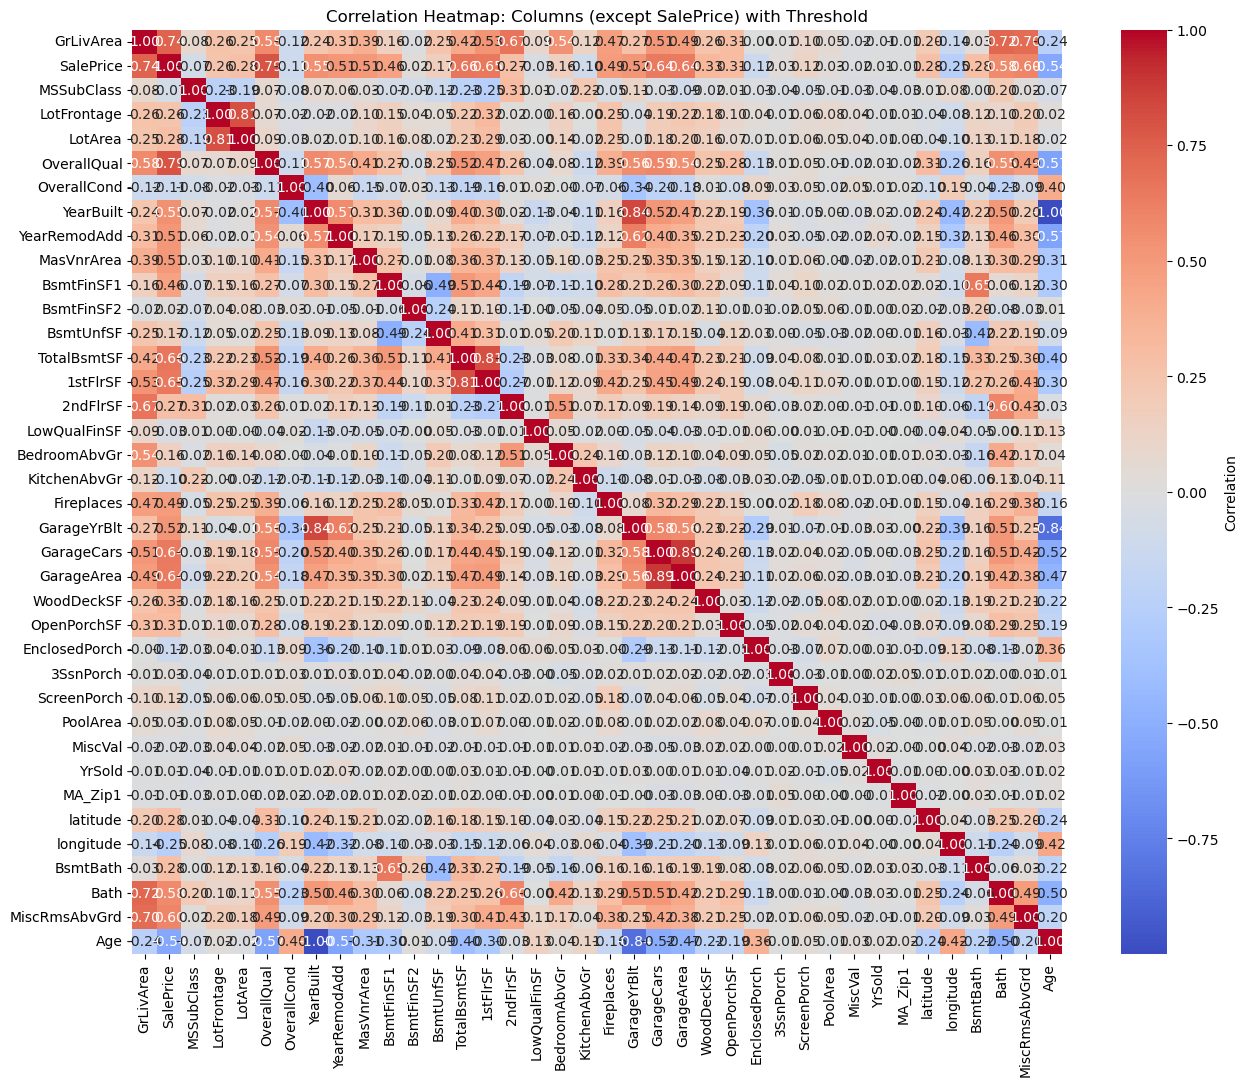

In [572]:
# Drop the 'SalePrice' column from the dataset
without_saleprice = housing_coords.drop(columns=['PID', 'GeoRefNo'])

# Calculate the correlation matrix
corr_matrix = without_saleprice.corr()

# Choose a larger figure size
plt.figure(figsize=(15, 12))

# Adjust the palette as needed
cmap = sns.color_palette("coolwarm", as_cmap=True)

# # Set the threshold for displaying color
# threshold = 0.5

# # Create a mask to hide values below the threshold
# mask = corr_matrix.abs() <= threshold

# Create a heatmap using Seaborn with the masked values
heatmap = sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".2f", cbar_kws={'label': 'Correlation'})#, mask=mask)

plt.title('Correlation Heatmap: Columns (except SalePrice) with Threshold')
plt.show()

In [579]:
abs(housing_coords.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/688462789.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(housing_coords.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


OverallQual      0.794030
GrLivArea        0.735870
TotalBsmtSF      0.662840
1stFlrSF         0.651540
GarageCars       0.644857
GarageArea       0.638622
MiscRmsAbvGrd    0.595104
Bath             0.576539
YearBuilt        0.545151
Age              0.544842
GarageYrBlt      0.520474
YearRemodAdd     0.509824
MasVnrArea       0.506583
Fireplaces       0.488735
BsmtFinSF1       0.460579
WoodDeckSF       0.334867
OpenPorchSF      0.305583
BsmtBath         0.282844
latitude         0.276901
LotArea          0.275300
2ndFlrSF         0.274968
LotFrontage      0.257126
longitude        0.251803
PID              0.228917
GeoRefNo         0.228917
BsmtUnfSF        0.169437
BedroomAbvGr     0.161496
EnclosedPorch    0.124848
ScreenPorch      0.122067
OverallCond      0.109348
KitchenAbvGr     0.096739
MSSubClass       0.074732
LowQualFinSF     0.030963
3SsnPorch        0.030009
PoolArea         0.026005
BsmtFinSF2       0.022873
MiscVal          0.021669
MA_Zip1          0.011569
YrSold      

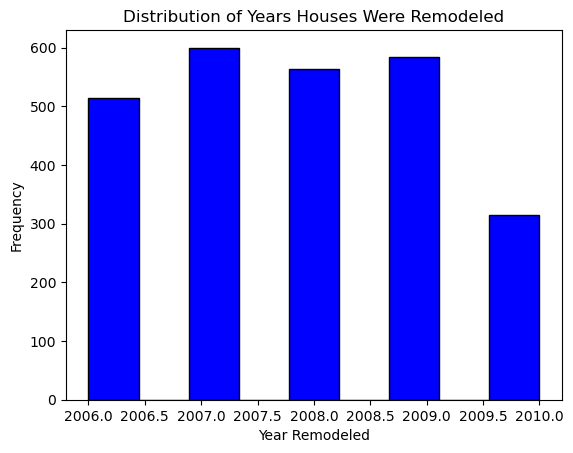

In [518]:
plt.hist(housing_coords['YrSold'], bins=9, color='blue', edgecolor='black')
plt.title('Distribution of Years Houses Were Remodeled')
plt.xlabel('Year Remodeled')
plt.ylabel('Frequency')
plt.show()

In [503]:
housing_coords['YrSold'] = housing_coords['YrSold'].astype(str)


In [521]:
housing_coords.YrSold

0       2010
1       2009
3       2007
4       2009
5       2009
        ... 
2618    2009
2619    2009
2620    2007
2621    2007
2622    2006
Name: YrSold, Length: 2579, dtype: int64

In [511]:
housing_coords['YrSold'] = housing_coords['YrSold'].astype(int)


In [512]:
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
# housing_coords['Age_Remod'] = housing_coords['YrSold'] = housing_coords['YearRemodAdd']

In [513]:
housing_coords[['YearRemodAdd','YearBuilt','Age']].describe()

,YearRemodAdd,YearBuilt,Age
count,2579.000000,2579.000000,2579.000000
mean,1983.765025,1970.325708,37.513377
std,20.483428,29.719469,29.729008
min,1950.000000,1872.000000,0.000000
25%,1965.000000,1953.000000,9.000000
50%,1992.000000,1972.000000,36.000000
75%,2003.000000,1999.000000,55.000000
max,2010.000000,2010.000000,136.000000


In [514]:
housing_coords.MoSold.value_counts()

6     459
7     400
5     363
4     252
3     209
8     193
10    148
9     131
2     120
11    117
1     101
12     86
Name: MoSold, dtype: int64

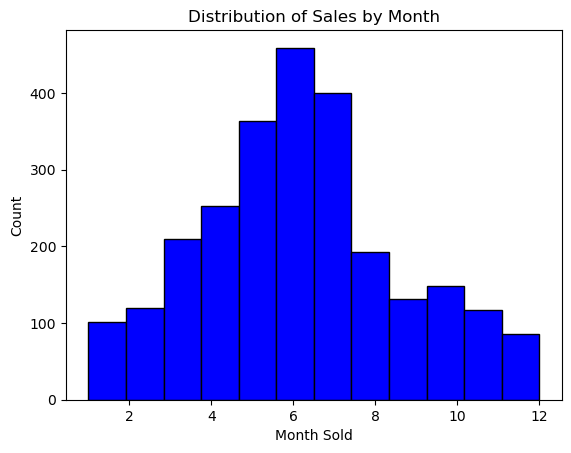

In [520]:
plt.hist(housing_coords['MoSold'], bins=12, color='blue', edgecolor='black')
plt.title('Distribution of Sales by Month')
plt.xlabel('Month Sold')
plt.ylabel('Count')
plt.show()

In [522]:
# housing_coords['YrSold'].astype(str)
# # Assuming 'column1' and 'column2' are the columns you want to concatenate
# housing_coords['YrMoSold'] = housing_coords['YrSold'].astype(str) + '-' + housing_coords['MoSold'].astype(str)


In [538]:
housing_coords['MoSold'] = housing_coords['MoSold'].astype(str).str.zfill(2)

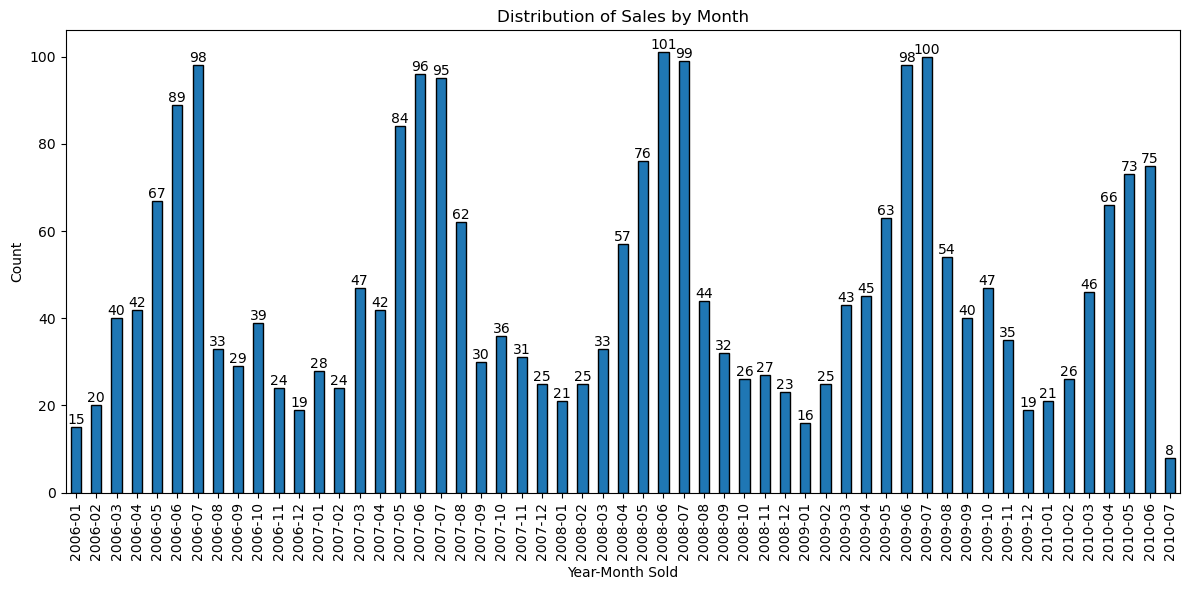

In [545]:
# Create a new column 'YearMonth' by combining 'Year' and 'Month'
plot_df=housing_coords.copy()
plot_df['YrMoSold'] = plot_df['YrSold'].astype(str) + '-' + plot_df['MoSold'].str.zfill(2)

# Count the occurrences of each Year-Month
sales_by_year_month = plot_df['YrMoSold'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sales_by_year_month.plot(kind='bar', edgecolor='black')

# Add count labels on each bar
for i, count in enumerate(sales_by_year_month):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Distribution of Sales by Month')
plt.xlabel('Year-Month Sold')
plt.ylabel('Count')

# Adjust x-axis ticks for even spacing between bars
plt.xticks(range(len(sales_by_year_month)), sales_by_year_month.index, rotation=90)
plt.tight_layout()

plt.show()

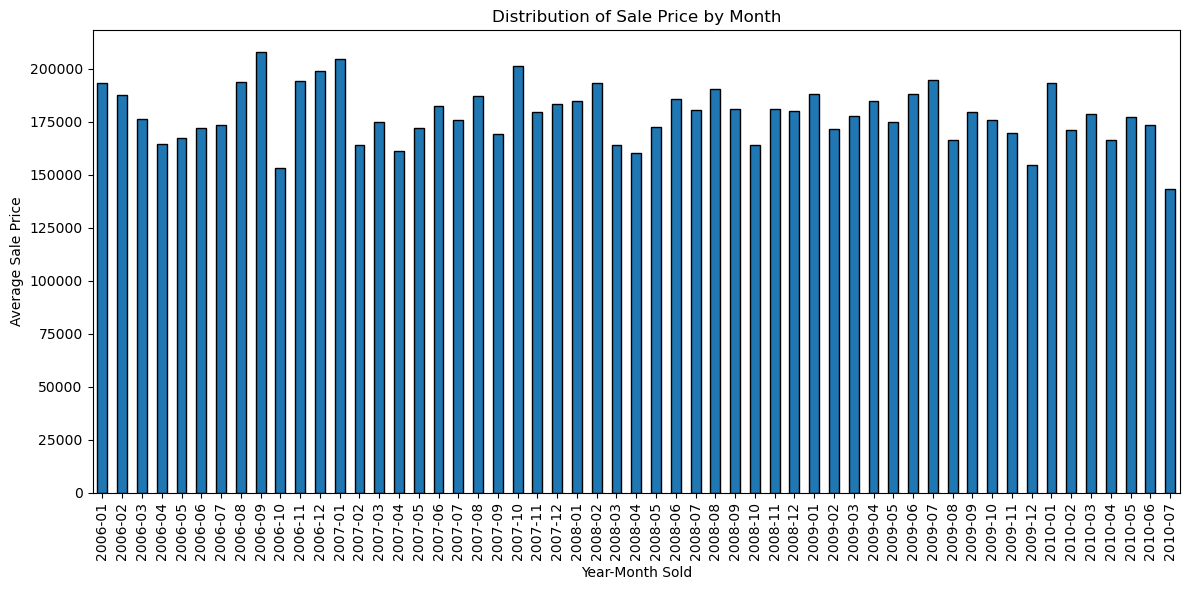

In [552]:
# Count the occurrences of each Year-Month
prices_by_year_month = round(housing_coords.groupby('YrMoSold')['SalePrice'].mean()).astype(int)

# Plot the bar chart
plt.figure(figsize=(12, 6))
prices_by_year_month.plot(kind='bar', edgecolor='black')

# # Add count labels on each bar
# for i, count in enumerate(prices_by_year_month):
#     plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Distribution of Sale Price by Month')
plt.xlabel('Year-Month Sold')
plt.ylabel('Average Sale Price')

# Adjust x-axis ticks for even spacing between bars
plt.xticks(range(len(prices_by_year_month)), prices_by_year_month.index, rotation=90)
plt.tight_layout()

plt.show()

In [561]:
# Remove missing gps data rows:
housing_coords = housing_coords.dropna(subset=['latitude'])

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']

# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

In [563]:
housing_coords.MA_Zip1.astype(int).value_counts().head(20)

50010    1507
50014     809
50226       8
50021       7
51301       5
50322       5
16801       5
50036       4
50050       4
50325       4
52240       3
32043       3
50023       3
50131       3
50035       3
50236       3
80448       2
50219       2
55906       2
50223       2
Name: MA_Zip1, dtype: int64

In [567]:
housing_coords.loc[housing_coords['MA_Zip1'].isin([50010, 50014]), 'MA_Zip1']


0       50010.0
1       50014.0
2       50010.0
3       50010.0
4       50010.0
         ...   
2491    50014.0
2492    50010.0
2493    50014.0
2495    50014.0
2496    50014.0
Name: MA_Zip1, Length: 2316, dtype: float64

In [568]:
housing_coords.shape

(2497, 87)

In [569]:
2497-2316

181

In [580]:
abs(housing_coords.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/1824313293.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(housing_coords.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


OverallQual      0.794030
GrLivArea        0.735870
TotalBsmtSF      0.662840
1stFlrSF         0.651540
GarageCars       0.644857
GarageArea       0.638622
MiscRmsAbvGrd    0.595104
Bath             0.576539
YearBuilt        0.545151
Age              0.544842
GarageYrBlt      0.520474
YearRemodAdd     0.509824
MasVnrArea       0.506583
Fireplaces       0.488735
BsmtFinSF1       0.460579
WoodDeckSF       0.334867
OpenPorchSF      0.305583
BsmtBath         0.282844
latitude         0.276901
LotArea          0.275300
2ndFlrSF         0.274968
LotFrontage      0.257126
longitude        0.251803
PID              0.228917
GeoRefNo         0.228917
BsmtUnfSF        0.169437
BedroomAbvGr     0.161496
EnclosedPorch    0.124848
ScreenPorch      0.122067
OverallCond      0.109348
KitchenAbvGr     0.096739
MSSubClass       0.074732
LowQualFinSF     0.030963
3SsnPorch        0.030009
PoolArea         0.026005
BsmtFinSF2       0.022873
MiscVal          0.021669
MA_Zip1          0.011569
YrSold      

In [583]:
test_df = housing_coords.copy()
test_df['BsmtSF'] = test_df['BsmtFinSF1'] + test_df['BsmtFinSF2'] + test_df['BsmtUnfSF']
test_df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'],axis=1,inplace=True)

abs(test_df.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')
print()

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/3493105181.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(test_df.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


In [586]:
test_df = housing_coords.copy()
test_df['TOTALLIVSPACE'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['LowQualFinSF']
# test_df.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'],axis=1,inplace=True)

abs(test_df.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/3440145509.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(test_df.corr())['SalePrice'].sort_values(ascending=False).drop('SalePrice')


OverallQual      0.794030
TOTALLIVSPACE    0.735870
GrLivArea        0.735870
TotalBsmtSF      0.662840
1stFlrSF         0.651540
GarageCars       0.644857
GarageArea       0.638622
MiscRmsAbvGrd    0.595104
Bath             0.576539
YearBuilt        0.545151
Age              0.544842
GarageYrBlt      0.520474
YearRemodAdd     0.509824
MasVnrArea       0.506583
Fireplaces       0.488735
BsmtFinSF1       0.460579
WoodDeckSF       0.334867
OpenPorchSF      0.305583
BsmtBath         0.282844
latitude         0.276901
LotArea          0.275300
2ndFlrSF         0.274968
LotFrontage      0.257126
longitude        0.251803
PID              0.228917
GeoRefNo         0.228917
BsmtUnfSF        0.169437
BedroomAbvGr     0.161496
EnclosedPorch    0.124848
ScreenPorch      0.122067
OverallCond      0.109348
KitchenAbvGr     0.096739
MSSubClass       0.074732
LowQualFinSF     0.030963
3SsnPorch        0.030009
PoolArea         0.026005
BsmtFinSF2       0.022873
MiscVal          0.021669
MA_Zip1     

In [588]:
housing.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice')

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/2307243653.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing.corr()['SalePrice'].sort_values(ascending=False).drop('SalePrice')


OverallQual      0.790661
GrLivArea        0.719980
TotalBsmtSF      0.652268
1stFlrSF         0.642623
GarageCars       0.639017
GarageArea       0.635029
YearBuilt        0.544569
FullBath         0.535175
GarageYrBlt      0.521105
YearRemodAdd     0.514720
MasVnrArea       0.501047
TotRmsAbvGrd     0.490206
Fireplaces       0.488173
BsmtFinSF1       0.460778
LotFrontage      0.358550
WoodDeckSF       0.333332
OpenPorchSF      0.306629
BsmtFullBath     0.291191
HalfBath         0.285861
LotArea          0.274427
2ndFlrSF         0.263115
BsmtUnfSF        0.167578
BedroomAbvGr     0.151924
ScreenPorch      0.121392
3SsnPorch        0.031269
PoolArea         0.030849
BsmtFinSF2       0.022545
MoSold           0.012725
YrSold          -0.001261
MiscVal         -0.018869
LowQualFinSF    -0.030827
BsmtHalfBath    -0.033781
MSSubClass      -0.084574
OverallCond     -0.101123
KitchenAbvGr    -0.113962
EnclosedPorch   -0.123209
PID             -0.226410
Name: SalePrice, dtype: float64

In [596]:
housing_coords.FireplaceQu.value_counts()

Gd    596
TA    554
Fa     70
Po     42
Ex     34
Name: FireplaceQu, dtype: int64

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/1637814922.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  housing_coords.groupby('PoolQC').mean()['SalePrice']


PoolQC
Ex    615000.0
Fa    215500.0
Gd    215500.0
TA    170500.0
Name: SalePrice, dtype: float64

In [621]:
housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

KeyError: "['PoolQC', 'MiscFeature', 'Alley', 'Fence'] not found in axis"

In [614]:
test_df = housing_coords.groupby('FireplaceQu').mean()['SalePrice']
test_df[:]
# plt.hist(, color='blue', edgecolor='black')
# plt.title('Distribution of Sales by Month')
# plt.xlabel('Month Sold')
# plt.ylabel('Count')
# plt.show()

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/578458738.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df = housing_coords.groupby('FireplaceQu').mean()['SalePrice']


FireplaceQu
Ex    338016.441176
Fa    168482.142857
Gd    222898.703020
Po    142588.880952
TA    205633.785199
Name: SalePrice, dtype: float64

In [616]:
housing_coords.FireplaceQu.isna().value_counts()

False    1296
True     1201
Name: FireplaceQu, dtype: int64

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/2298465272.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = housing_coords.groupby('FireplaceQu').mean()['SalePrice']


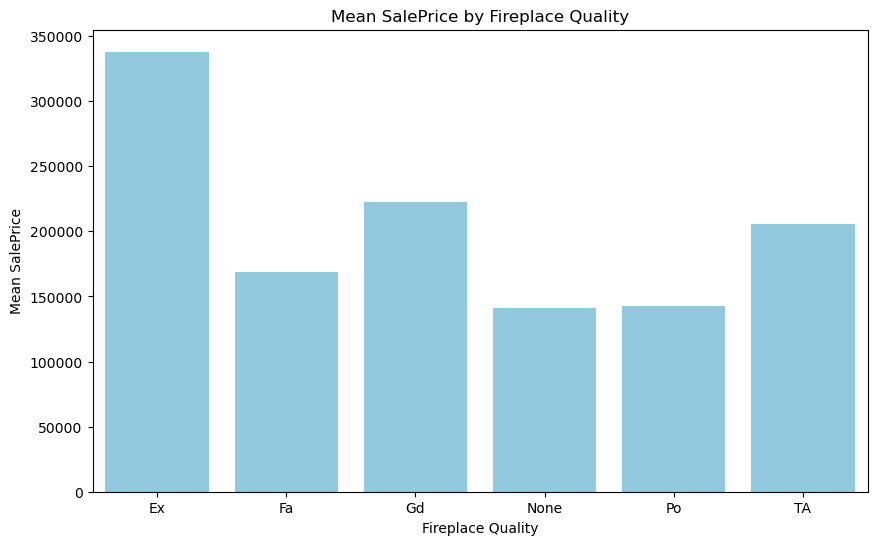

In [624]:
grouped_data = housing_coords.groupby('FireplaceQu').mean()['SalePrice']

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.index, y=grouped_data.values, color='skyblue')
plt.title('Mean SalePrice by Fireplace Quality')
plt.xlabel('Fireplace Quality')
plt.ylabel('Mean SalePrice')
plt.show()

In [618]:
# Fill NaN with 'None' for categorical columns
categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 
                        'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 
                        'BsmtFinType2', 'BsmtExposure']

housing_coords[categorical_features] = housing_coords[categorical_features].fillna('None')

/var/folders/5v/y3sknb9x0fzg1jwjw5jw77tm0000gn/T/ipykernel_53251/405558170.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_coords[categorical_features] = housing_coords[categorical_features].fillna('None')
